In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import matplotlib.pyplot as plt
from chnet.torchsummary import summary
from torchvision import transforms, utils
from toolz.curried import pipe, curry, compose
from torch.utils.data import Dataset, DataLoader

In [3]:
import utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools

In [4]:
from chnet.unet import UNet
from chnet.ch_net import CHnet
from chnet.ch_loader import CahnHillDataset

In [5]:
warnings.filterwarnings('ignore')

In [6]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

In [7]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Loss Functions

In [8]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Transformers

In [9]:
@curry
def add_neighbors(x):
    dimx = x.shape[0]
    y = np.pad(x, pad_width=[[2,2],[2,2]], mode="wrap")
    out = [x[None]]
    for ix in [0, 1, 2, 3, 4]:
        for iy in [0, 1, 2, 3, 4]:
            out.append((y[ix:ix+dimx, iy:iy+dimx] * x)[None])
    return np.concatenate(out, axis=0)

## Data Generators

In [10]:
@curry
def data_generator(nsamples=16, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

# Set Device

In [11]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")

## Data Generation

In [12]:
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = device)

# CNN Model

In [13]:
# model = torch.hub.load('pytorch/vision:v0.5.0', 'fcn_resnet101', pretrained=False)
# summary(model, input_size=(1, 64, 64))

# # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
# #                        in_channels=1, 
# #                        out_channels=1, 
# #                        init_features=32, 
# #                        pretrained=False).double().to(device)

In [13]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [21]:
from chnet.unet import UNet
from chnet.vae import VAE
model = VAE(in_channels=1, out_channels=1).double().to(device)

In [23]:
summary(model, dtypes=[torch.double], input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]             544
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 6, 6]         131,200
              ReLU-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 256, 2, 2]         524,544
              ReLU-8            [-1, 256, 2, 2]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 32]          32,800
           Linear-11                   [-1, 32]          32,800
           Linear-12                 [-1, 1024]          33,792
        UnFlatten-13           [-1, 1024, 1, 1]               0
  ConvTranspose2d-14            [-1, 12

(tensor(4345217), tensor(4345217))

In [16]:
model = VAE(in_channels=1, out_channels=1).double().to(device)
item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.0038, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [38]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 5000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*20
n_samples_val = 128
n_samples_prd = 32

init_features=64

In [39]:
args = {}
args["dim_x"] = dim_x
args["init_steps"] = init_steps
args["delta_sim_steps"] = delta_sim_steps
args["dx"] = dx
args["dt"] = dt
args["gamma"] = gamma
args["seed_trn"] = seed_trn
args["seed_val"] = seed_val
args["seed_val"] = seed_prd

args["n_samples_trn"] = n_samples_trn
args["n_samples_val"] = n_samples_val
args["n_samples_prd"] = n_samples_prd

args["init_features"] = init_features

In [40]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = device)



x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = device)

x_prd, y_prd = data_generator(nsamples=n_samples_prd, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd,
                                device = device)

CPU times: user 1min 30s, sys: 1min 29s, total: 2min 59s
Wall time: 2min 57s


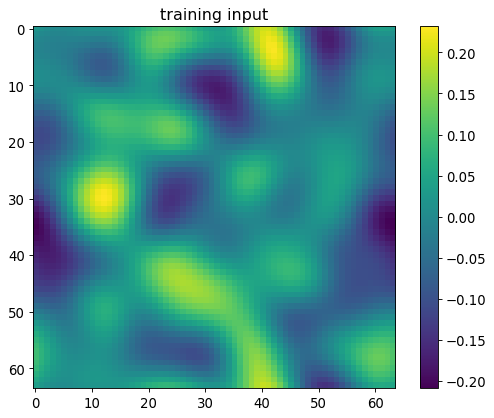

In [41]:
draw_im(x_trn[0], "training input")

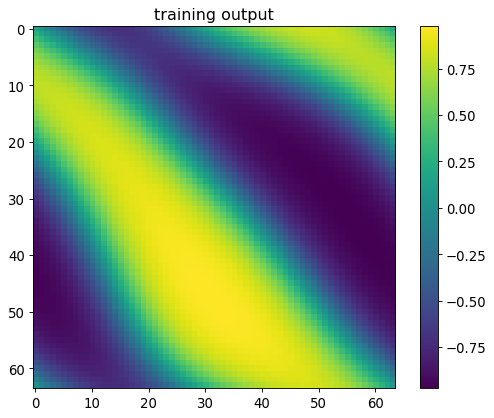

In [42]:
draw_im(y_trn[0], "training output")

In [43]:
transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=transformer_x, transform_y=transformer_y)
val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
prd_dataset = CahnHillDataset(x_prd, y_prd, transform_x=transformer_x, transform_y=transformer_y)

batch_size = 32

trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
prd_loader = DataLoader(prd_dataset, batch_size=8, shuffle=True, num_workers=1)


total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)
total_val_step = len(val_loader)
print("No. of validation steps: %d" % total_val_step)
total_val_step = len(prd_loader)
print("No. of prediction steps: %d" % total_val_step)

No. of training steps: 640
No. of validation steps: 4
No. of prediction steps: 4


In [44]:
dt_string = datetime.now().strftime("%d-%m-%Y-%H-%M")

In [45]:
run = 5
run_id = dt_string + "_run_" +str(run)
print(run_id)

folder = "out/unet/ch_unet_id_{}/".format(run_id)
print(folder)

if not os.path.exists(folder):
    os.makedirs(folder)
    
with open(folder+'params.json', 'w') as fp:
    json.dump(args, fp)
    
tag = folder+"unet_"
print(tag)

11-04-2020-15-52_run_5
out/unet/ch_unet_id_11-04-2020-15-52_run_5/
out/unet/ch_unet_id_11-04-2020-15-52_run_5/unet_


In [46]:
from chnet.vae import VAE
model = VAE(in_channels=1, out_channels=1).double().to(device)

In [48]:
num_epochs = 50
criterion = mse_loss(scale=10000)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [51]:
# Loss and optimizer
for epoch in range(num_epochs):    
    torch.save(model.state_dict(), tag+"epoch_{}.pt".format(epoch))              
    for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):
        
        
        model.train()
        
        x = item_trn['x'].to(device)
        y_tru = item_trn['y'].to(device)

        # Forward pass
        y_prd = model(x)[0]
        loss = criterion(y_tru, y_prd)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trn_losses.append(np.sqrt(loss.item()))
        
        if (i) % 256 == 0:
            for item_val in val_loader:
                model.eval()
                x1 = item_trn['x'].to(device)
                y1 = item_trn['y'].to(device)
                # Forward pass
                y2 = model(x1)[0]
                val_losses.append(np.sqrt(criterion(y2, y1).item()))
                    
            print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}, Validation Loss: {:.11f}'.format(epoch+1, 
                                                                                                          num_epochs, 
                                                                                                          i+1, 
                                                                                                          total_step, 
                                                                                                          np.mean(trn_losses[-16:]), 
                                                                                                          np.mean(val_losses[-total_val_step:])))
            
# torch.save(model.state_dict(), tag+"epoch_{}.pt".format(num_epochs)) 

Epoch [1/50], Step [1/640], Training Loss: 69.38012490067, Validation Loss: 69.56441976640
Epoch [1/50], Step [257/640], Training Loss: 69.42728438868, Validation Loss: 69.72329035648
Epoch [1/50], Step [513/640], Training Loss: 69.59803068885, Validation Loss: 69.85372632266



Epoch [2/50], Step [1/640], Training Loss: 69.52265052624, Validation Loss: 69.59861100002
Epoch [2/50], Step [257/640], Training Loss: 69.39648898055, Validation Loss: 69.81380778582
Epoch [2/50], Step [513/640], Training Loss: 69.55072785309, Validation Loss: 69.64623787773



Epoch [3/50], Step [1/640], Training Loss: 69.60135771786, Validation Loss: 69.69543943337
Epoch [3/50], Step [257/640], Training Loss: 69.44953726302, Validation Loss: 69.78011688207
Epoch [3/50], Step [513/640], Training Loss: 69.50426050350, Validation Loss: 69.75776310880



Epoch [4/50], Step [1/640], Training Loss: 69.39596927077, Validation Loss: 69.48996742893
Epoch [4/50], Step [257/640], Training Loss: 69.55071964843, Validation Loss: 69.81043750041
Epoch [4/50], Step [513/640], Training Loss: 69.41700205654, Validation Loss: 69.74271669226



Epoch [5/50], Step [1/640], Training Loss: 69.53444167632, Validation Loss: 69.38713795994
Epoch [5/50], Step [257/640], Training Loss: 69.61188389340, Validation Loss: 70.04057264568
Epoch [5/50], Step [513/640], Training Loss: 69.57560993650, Validation Loss: 69.81771772415



Epoch [6/50], Step [1/640], Training Loss: 69.62029306550, Validation Loss: 69.53760491220
Epoch [6/50], Step [257/640], Training Loss: 69.40753313731, Validation Loss: 69.54554596553
Epoch [6/50], Step [513/640], Training Loss: 69.53687028000, Validation Loss: 69.50454512851



Epoch [7/50], Step [1/640], Training Loss: 69.61443254213, Validation Loss: 69.66021767336
Epoch [7/50], Step [257/640], Training Loss: 69.39277753215, Validation Loss: 68.79369044956
Epoch [7/50], Step [513/640], Training Loss: 69.37752594489, Validation Loss: 69.19211630280



Epoch [8/50], Step [1/640], Training Loss: 69.51369215180, Validation Loss: 69.48919958890
Epoch [8/50], Step [257/640], Training Loss: 69.52521537568, Validation Loss: 69.66154638847
Epoch [8/50], Step [513/640], Training Loss: 69.54171523088, Validation Loss: 69.88137608230



Epoch [9/50], Step [1/640], Training Loss: 69.60087331775, Validation Loss: 69.29334146904
Epoch [9/50], Step [257/640], Training Loss: 69.46968239425, Validation Loss: 69.07417054986
Epoch [9/50], Step [513/640], Training Loss: 69.70542231919, Validation Loss: 69.07658276736



Epoch [10/50], Step [1/640], Training Loss: 69.48622000182, Validation Loss: 69.14430670125
Epoch [10/50], Step [257/640], Training Loss: 69.62601275332, Validation Loss: 69.38442002100
Epoch [10/50], Step [513/640], Training Loss: 69.43836811464, Validation Loss: 69.51843886879



Epoch [11/50], Step [1/640], Training Loss: 69.52692833647, Validation Loss: 68.87062296892
Epoch [11/50], Step [257/640], Training Loss: 69.57990150458, Validation Loss: 69.57366890899
Epoch [11/50], Step [513/640], Training Loss: 69.45219280872, Validation Loss: 69.80984193391



Epoch [12/50], Step [1/640], Training Loss: 69.54171298207, Validation Loss: 69.64239705871
Epoch [12/50], Step [257/640], Training Loss: 69.52640359404, Validation Loss: 69.40240013869
Epoch [12/50], Step [513/640], Training Loss: 69.50520006606, Validation Loss: 70.00471204977



Epoch [13/50], Step [1/640], Training Loss: 69.58633663870, Validation Loss: 69.12670917362
Epoch [13/50], Step [257/640], Training Loss: 69.38488878676, Validation Loss: 69.68968704370
Epoch [13/50], Step [513/640], Training Loss: 69.47901581605, Validation Loss: 69.36273601447



Epoch [14/50], Step [1/640], Training Loss: 69.58075899175, Validation Loss: 69.70151769645
Epoch [14/50], Step [257/640], Training Loss: 69.54069695233, Validation Loss: 69.85038697443
Epoch [14/50], Step [513/640], Training Loss: 69.56206760863, Validation Loss: 69.80938292345



Epoch [15/50], Step [1/640], Training Loss: 69.54648148226, Validation Loss: 69.48098214352
Epoch [15/50], Step [257/640], Training Loss: 69.39501277990, Validation Loss: 69.46608501048
Epoch [15/50], Step [513/640], Training Loss: 69.50327378066, Validation Loss: 69.63831164378



Epoch [16/50], Step [1/640], Training Loss: 69.50491883746, Validation Loss: 69.23994796816
Epoch [16/50], Step [257/640], Training Loss: 69.48920567054, Validation Loss: 69.68932646704
Epoch [16/50], Step [513/640], Training Loss: 69.62839169464, Validation Loss: 69.54535303806



Epoch [17/50], Step [1/640], Training Loss: 69.53673008676, Validation Loss: 70.17922889883
Epoch [17/50], Step [257/640], Training Loss: 69.50822307587, Validation Loss: 69.60700616172
Epoch [17/50], Step [513/640], Training Loss: 69.54850701397, Validation Loss: 69.54379507806



Epoch [18/50], Step [1/640], Training Loss: 69.39361632053, Validation Loss: 69.21435132171
Epoch [18/50], Step [257/640], Training Loss: 69.64278483149, Validation Loss: 69.50713189613
Epoch [18/50], Step [513/640], Training Loss: 69.53860453749, Validation Loss: 69.29021319383



Epoch [19/50], Step [1/640], Training Loss: 69.51095728504, Validation Loss: 69.61356636472
Epoch [19/50], Step [257/640], Training Loss: 69.64321559905, Validation Loss: 69.67208809541
Epoch [19/50], Step [513/640], Training Loss: 69.60162175223, Validation Loss: 70.36547688921



Epoch [20/50], Step [1/640], Training Loss: 69.62265821945, Validation Loss: 69.53253451442
Epoch [20/50], Step [257/640], Training Loss: 69.51121254770, Validation Loss: 69.60928992313
Epoch [20/50], Step [513/640], Training Loss: 69.52514392482, Validation Loss: 70.16848707812



Epoch [21/50], Step [1/640], Training Loss: 69.57354988896, Validation Loss: 69.43118222899
Epoch [21/50], Step [257/640], Training Loss: 69.50727401912, Validation Loss: 69.26815336315
Epoch [21/50], Step [513/640], Training Loss: 69.51803902400, Validation Loss: 69.51346473369



Epoch [22/50], Step [1/640], Training Loss: 69.69597704400, Validation Loss: 69.19080699186
Epoch [22/50], Step [257/640], Training Loss: 69.56418384217, Validation Loss: 69.29666538474
Epoch [22/50], Step [513/640], Training Loss: 69.51894555593, Validation Loss: 69.17768567960



Epoch [23/50], Step [1/640], Training Loss: 69.47633288193, Validation Loss: 69.52286887593
Epoch [23/50], Step [257/640], Training Loss: 69.58406068384, Validation Loss: 69.55798249353
Epoch [23/50], Step [513/640], Training Loss: 69.52913419490, Validation Loss: 69.34474225608



Epoch [24/50], Step [1/640], Training Loss: 69.55413661369, Validation Loss: 69.10916247739
Epoch [24/50], Step [257/640], Training Loss: 69.66136141682, Validation Loss: 69.60669173971
Epoch [24/50], Step [513/640], Training Loss: 69.40698421028, Validation Loss: 69.30433070487



Epoch [25/50], Step [1/640], Training Loss: 69.49481102329, Validation Loss: 69.44509050507
Epoch [25/50], Step [257/640], Training Loss: 69.51167132541, Validation Loss: 69.20319126642
Epoch [25/50], Step [513/640], Training Loss: 69.50959548618, Validation Loss: 69.15491031771



Epoch [26/50], Step [1/640], Training Loss: 69.53372251702, Validation Loss: 69.10791844135
Epoch [26/50], Step [257/640], Training Loss: 69.48764515450, Validation Loss: 69.59735286051
Epoch [26/50], Step [513/640], Training Loss: 69.40202873861, Validation Loss: 69.40626065898



Epoch [27/50], Step [1/640], Training Loss: 69.51703395466, Validation Loss: 69.86285560325
Epoch [27/50], Step [257/640], Training Loss: 69.59833157153, Validation Loss: 69.41259885426
Epoch [27/50], Step [513/640], Training Loss: 69.60767838803, Validation Loss: 69.42218620880



Epoch [28/50], Step [1/640], Training Loss: 69.56648353587, Validation Loss: 69.42277832582
Epoch [28/50], Step [257/640], Training Loss: 69.56046497076, Validation Loss: 69.54057956265
Epoch [28/50], Step [513/640], Training Loss: 69.49243885357, Validation Loss: 69.36885616842



Epoch [29/50], Step [1/640], Training Loss: 69.54436314709, Validation Loss: 69.70891278732
Epoch [29/50], Step [257/640], Training Loss: 69.50855731572, Validation Loss: 69.70767787755
Epoch [29/50], Step [513/640], Training Loss: 69.63832578090, Validation Loss: 69.56200974977



Epoch [30/50], Step [1/640], Training Loss: 69.44128191358, Validation Loss: 69.28124852871
Epoch [30/50], Step [257/640], Training Loss: 69.41701301013, Validation Loss: 69.45808610461
Epoch [30/50], Step [513/640], Training Loss: 69.61395717075, Validation Loss: 69.50648042195



Epoch [31/50], Step [1/640], Training Loss: 69.62116369165, Validation Loss: 69.60579205710
Epoch [31/50], Step [257/640], Training Loss: 69.45684167130, Validation Loss: 68.74187670487
Epoch [31/50], Step [513/640], Training Loss: 69.45978077940, Validation Loss: 69.89434479597



Epoch [32/50], Step [1/640], Training Loss: 69.50421947635, Validation Loss: 68.80627223216
Epoch [32/50], Step [257/640], Training Loss: 69.58136202705, Validation Loss: 69.73478711986
Epoch [32/50], Step [513/640], Training Loss: 69.55323179731, Validation Loss: 69.33087291503



Epoch [33/50], Step [1/640], Training Loss: 69.53567394927, Validation Loss: 68.96836452091
Epoch [33/50], Step [257/640], Training Loss: 69.52495656965, Validation Loss: 69.18606471622
Epoch [33/50], Step [513/640], Training Loss: 69.59991495943, Validation Loss: 69.66852598413



Epoch [34/50], Step [1/640], Training Loss: 69.44809230626, Validation Loss: 68.90796877952
Epoch [34/50], Step [257/640], Training Loss: 69.29207072827, Validation Loss: 69.22626919561
Epoch [34/50], Step [513/640], Training Loss: 69.55748561658, Validation Loss: 69.72512761700



Epoch [35/50], Step [1/640], Training Loss: 69.55505276273, Validation Loss: 69.33274440638
Epoch [35/50], Step [257/640], Training Loss: 69.53195295228, Validation Loss: 69.78520639721
Epoch [35/50], Step [513/640], Training Loss: 69.49049533888, Validation Loss: 69.93901074437



Epoch [36/50], Step [1/640], Training Loss: 69.55933031486, Validation Loss: 69.48506750482
Epoch [36/50], Step [257/640], Training Loss: 69.59406035026, Validation Loss: 69.71252902959
Epoch [36/50], Step [513/640], Training Loss: 69.57151446322, Validation Loss: 69.64690338725



Epoch [37/50], Step [1/640], Training Loss: 69.47615124545, Validation Loss: 69.20484343237
Epoch [37/50], Step [257/640], Training Loss: 69.62306091277, Validation Loss: 70.07318495841
Epoch [37/50], Step [513/640], Training Loss: 69.57370511347, Validation Loss: 69.41903282917



Epoch [38/50], Step [1/640], Training Loss: 69.52352257792, Validation Loss: 69.64138766352
Epoch [38/50], Step [257/640], Training Loss: 69.55958869469, Validation Loss: 69.58754630164
Epoch [38/50], Step [513/640], Training Loss: 69.56790576229, Validation Loss: 69.72191428382



Epoch [39/50], Step [1/640], Training Loss: 69.52579316594, Validation Loss: 69.65182815375
Epoch [39/50], Step [257/640], Training Loss: 69.45946818169, Validation Loss: 69.25812009679
Epoch [39/50], Step [513/640], Training Loss: 69.56835955281, Validation Loss: 69.30577908751



Epoch [40/50], Step [1/640], Training Loss: 69.43869483516, Validation Loss: 69.64474646990
Epoch [40/50], Step [257/640], Training Loss: 69.53592117317, Validation Loss: 69.41132075018
Epoch [40/50], Step [513/640], Training Loss: 69.54870406778, Validation Loss: 69.50123064033



Epoch [41/50], Step [1/640], Training Loss: 69.55358314121, Validation Loss: 69.45801389609
Epoch [41/50], Step [257/640], Training Loss: 69.45872764596, Validation Loss: 68.99685513148
Epoch [41/50], Step [513/640], Training Loss: 69.58590429059, Validation Loss: 69.85246649376



Epoch [42/50], Step [1/640], Training Loss: 69.49368872614, Validation Loss: 69.35184639615
Epoch [42/50], Step [257/640], Training Loss: 69.51424207914, Validation Loss: 69.56089723080
Epoch [42/50], Step [513/640], Training Loss: 69.49181455787, Validation Loss: 69.83463189002



Epoch [43/50], Step [1/640], Training Loss: 69.59741624092, Validation Loss: 69.86263589560
Epoch [43/50], Step [257/640], Training Loss: 69.56001213531, Validation Loss: 69.48748233788
Epoch [43/50], Step [513/640], Training Loss: 69.49260669006, Validation Loss: 69.45792279134



Epoch [44/50], Step [1/640], Training Loss: 69.43258364251, Validation Loss: 69.68066939032
Epoch [44/50], Step [257/640], Training Loss: 69.46543780824, Validation Loss: 69.35003116972
Epoch [44/50], Step [513/640], Training Loss: 69.50435504644, Validation Loss: 69.68873683832



Epoch [45/50], Step [1/640], Training Loss: 69.44711333270, Validation Loss: 69.44103320611
Epoch [45/50], Step [257/640], Training Loss: 69.64343683147, Validation Loss: 69.84244777146
Epoch [45/50], Step [513/640], Training Loss: 69.39489691390, Validation Loss: 69.79518600949



Epoch [46/50], Step [1/640], Training Loss: 69.53530015509, Validation Loss: 69.45666110583
Epoch [46/50], Step [257/640], Training Loss: 69.54122022911, Validation Loss: 69.12312918617
Epoch [46/50], Step [513/640], Training Loss: 69.50952713898, Validation Loss: 69.37549730583



Epoch [47/50], Step [1/640], Training Loss: 69.49325309157, Validation Loss: 69.62472900672
Epoch [47/50], Step [257/640], Training Loss: 69.54622796788, Validation Loss: 69.39699391969
Epoch [47/50], Step [513/640], Training Loss: 69.59015459627, Validation Loss: 69.08610811529



Epoch [48/50], Step [1/640], Training Loss: 69.43353982749, Validation Loss: 69.27520315313
Epoch [48/50], Step [257/640], Training Loss: 69.54179618158, Validation Loss: 69.49277096734
Epoch [48/50], Step [513/640], Training Loss: 69.38226927704, Validation Loss: 69.15937895407



Epoch [49/50], Step [1/640], Training Loss: 69.48508726510, Validation Loss: 69.80963828798
Epoch [49/50], Step [257/640], Training Loss: 69.47627858325, Validation Loss: 69.67113784586
Epoch [49/50], Step [513/640], Training Loss: 69.57282020842, Validation Loss: 69.98086511046



Epoch [50/50], Step [1/640], Training Loss: 69.54001518866, Validation Loss: 69.46346234111
Epoch [50/50], Step [257/640], Training Loss: 69.49985548800, Validation Loss: 69.58778916016
Epoch [50/50], Step [513/640], Training Loss: 69.56303228981, Validation Loss: 69.09593947980



In [10]:
plt.plot(trn_losses)
plt.plot(val_losses)
plt.title("training losses")
plt.xlabel("training steps")
plt.ylabel("mean squared error")
plt.legend(["trn", "val"])
plt.show()

NameError: name 'trn_losses' is not defined

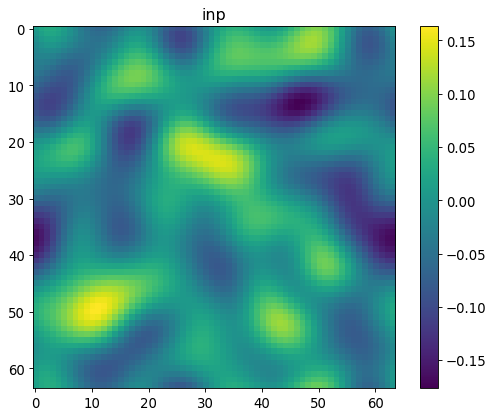

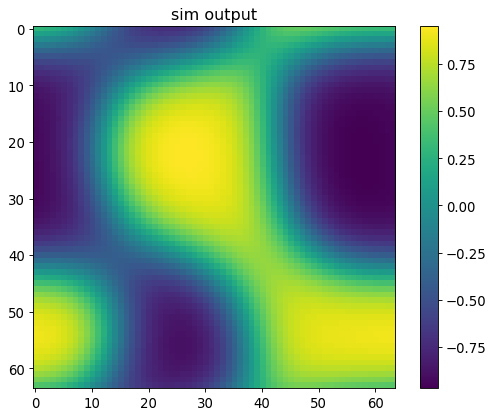

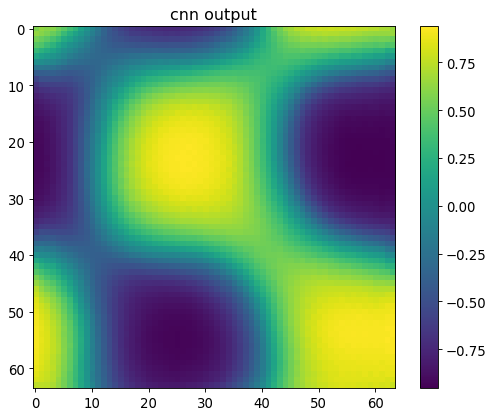

In [72]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

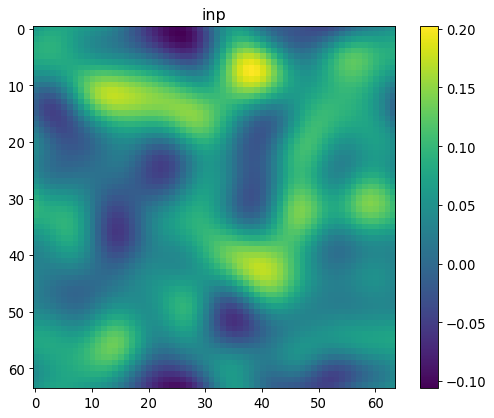

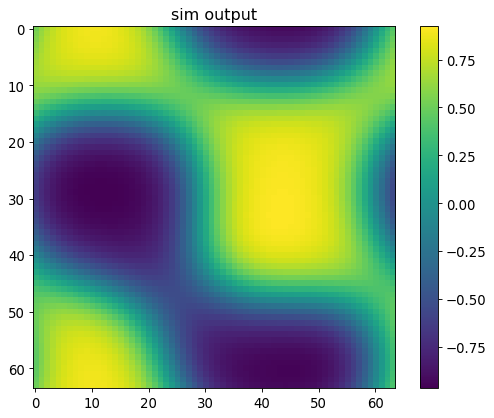

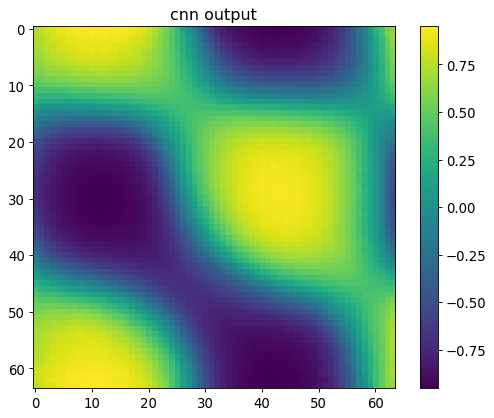

In [74]:
ix = 30

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")